In [240]:
import pandas as pd
import torch
import torch.nn as nn
from utils import get_data, min_max_normalize, prepare_data, create_dataloaders, set_seed, plot_grid_points
from model import MembraneModel, Trainer, ModelPredictor
import numpy as np
from scipy.stats import qmc
from scipy.spatial.distance import cdist
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess



# set seed for reproducibility
set_seed(42)
generator = torch.Generator()
generator.manual_seed(42)

# Pfade
data_csv = '../../../data/interpolation/auswertung_gesamt_8N_10N_12N_15N_17N_18N_20N.csv'

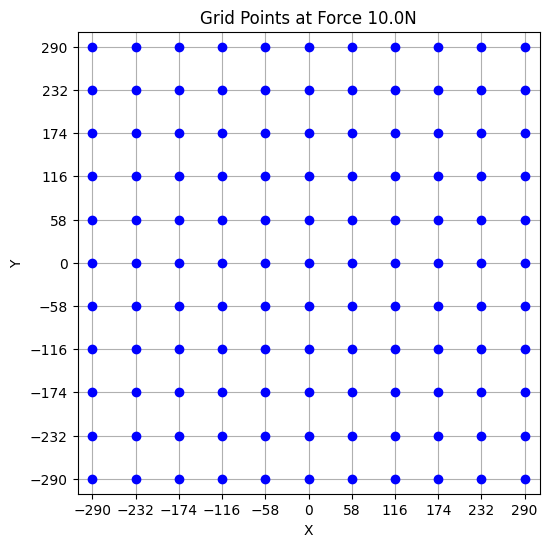

In [2]:
data = get_data(data_csv)
norm_data_original, mins, maxs = min_max_normalize(data)
plot_grid_points(norm_data_original, force=10.0)


In [47]:
def generate_lhs_maximin_points(
        norm_data_original=norm_data_original,
        force_value=10.0,
        k_start=20,
        k_end=30,
        k_step=2,
        n_lhs=10000,
        seed=0
    ):
    """
    Erzeugt LHS → Snap-to-Grid → Maximin-Auswahl für eine bestimmte Kraft.

    Parameters
    ----------
    norm_data_original : DataFrame
        Originaldaten mit Spalten ['F','X','Y'].
    force_value : float
        Welche Kraft soll extrahiert werden? z.B. 10.0
    k_start, k_end, k_step : int
        Bereich der Auswahlgrößen (z.B. 20–30).
    n_lhs : int
        Anzahl LHS-Kandidaten vor dem Snapping.
    seed : int
        Random Seed.

    Returns
    -------
    dict: {k: np.array((k, 2))}  # ausgewählte Punkte für jedes k
    """

    # --- 1. Filter Gridpunkte nach Kraft ---
    norm_data = norm_data_original[norm_data_original['F'] == force_value].reset_index(drop=True)
    points = norm_data[['X', 'Y']].to_numpy()

    # --- 2. LHS erzeugen ---
    sampler = qmc.LatinHypercube(d=2, seed=seed)
    sample = sampler.random(n=n_lhs)

    # --- 3. auf X/Y-Bereich skalieren ---
    sample = qmc.scale(
        sample,
        l_bounds=[points[:,0].min(), points[:,1].min()],
        u_bounds=[points[:,0].max(), points[:,1].max()]
    )

    # --- 4. Grid-Listen ---
    grid_x = np.sort(np.unique(points[:,0]))
    grid_y = np.sort(np.unique(points[:,1]))

    def snap_to_grid(sample):
        snapped = []
        for x, y in sample:
            x_s = grid_x[np.argmin(np.abs(grid_x - x))]
            y_s = grid_y[np.argmin(np.abs(grid_y - y))]
            snapped.append([x_s, y_s])
        return np.array(snapped)

    # --- 5. Snappen ---
    snapped = snap_to_grid(sample)

    # --- 6. Doppelte entfernen ---
    snapped_unique = np.unique(snapped, axis=0)

    # --- 7. Maximin-Auswahl ---
    def maximin_select(points_array, k):
        selected = [0]  # starte mit erstem Punkt
        for _ in range(k - 1):
            dist = cdist(points_array, points_array[selected])
            next_idx = np.argmax(dist.min(axis=1))
            selected.append(next_idx)
        return points_array[selected]

    # --- 8. Für jede k-Größe Ergebnisse erzeugen ---
    results = {}
    for k in range(k_start, k_end + 1, k_step):
        results[k] = maximin_select(snapped_unique, k)

    return results


In [48]:
epochs = 500
lr = 0.0013
batch_size = 64
test_losses = []
for F in [10.0, 15.0, 20.0]:
  print("training for F =", F)
  data_points = generate_lhs_maximin_points(force_value=F, k_start=10, k_end=121, k_step=1)
  for num_sample in data_points:
    norm_data_lhs = norm_data_original[norm_data_original['F'] == F].reset_index(drop=True).copy()
    norm_data_lhs = norm_data_lhs.merge(pd.DataFrame(data_points[num_sample], columns=['X', 'Y']), on=['X', 'Y'], how='inner')
    # Data with x and y only
    X_train_lhs, X_val_lhs, X_test_lhs, y_train_lhs, y_val_lhs, y_test_lhs = prepare_data(norm_data_lhs, targets='xy')
    train_loader_xy_lhs, val_loader_xy_lhs, test_loader_xy_lhs = create_dataloaders(X_train_lhs, X_val_lhs, X_test_lhs, y_train_lhs, y_val_lhs, y_test_lhs, batch_size=batch_size)

    model_xy_lhs = MembraneModel(output_dim=2)

    loss_fn_xy_lhs = nn.L1Loss()

    # Optimizers
    optimizer_xy_lhs = torch.optim.Adam(model_xy_lhs.parameters(), lr=lr)

    # Trainers
    trainer_xy_lhs = Trainer(model_xy_lhs, loss_fn_xy_lhs, optimizer_xy_lhs, device='cuda')
    # Training
    trainer_xy_lhs.fit(train_loader_xy_lhs, val_loader_xy_lhs, epochs=epochs)

    # Test Losses
    test_losses.append({"F": F, "num_points": num_sample, "test_loss": trainer_xy_lhs.test(test_loader_xy_lhs)})
#print(test_losses)
df_test_losses = pd.DataFrame(test_losses)
df_test_losses.to_csv("../../../data/lhs_test_losses.csv")




#trainer_xy_lhs.plot_losses()

training for F = 10.0
training for F = 15.0
training for F = 20.0


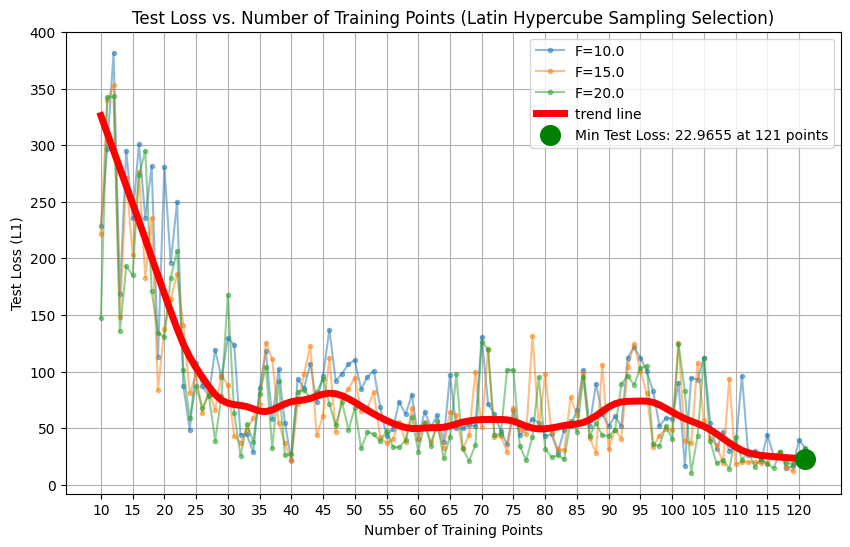

In [49]:
df_test_losses = pd.read_csv("../../../data/lhs_test_losses.csv")
plt.figure(figsize=(10,6))
for F in [10.0, 15.0, 20.0]:
    df_F = df_test_losses[df_test_losses['F'] == F].copy()
    x = df_F['num_points']
    y = df_F['test_loss']
    plt.plot(x, y, marker='o', label=f'F={F}', alpha=0.5, markersize=3)

x_all = df_test_losses['num_points']
y_all = df_test_losses['test_loss']
smoothed = lowess(y_all, x_all, frac=0.15)
plt.plot(smoothed[:, 0], smoothed[:, 1], linewidth=5, color='red', label='trend line')

idx_min = np.argmin(smoothed[:,1])
x_min = smoothed[idx_min, 0]
y_min = smoothed[idx_min, 1]
plt.scatter([x_min], [y_min], color='green', s=200, zorder=5, label=f'Min Test Loss: {y_min:.4f} at {int(x_min)} points')

plt.xlabel('Number of Training Points')
plt.ylabel('Test Loss (L1)')
plt.xticks(np.arange(10, 125, 5))
plt.yticks(np.arange(0, df_test_losses['test_loss'].max()+50, 50))
plt.title('Test Loss vs. Number of Training Points (Latin Hypercube Sampling Selection)')
plt.grid()
plt.legend()
plt.savefig("../../../figs/lhs_test_loss_vs_num_points.png", dpi=160)


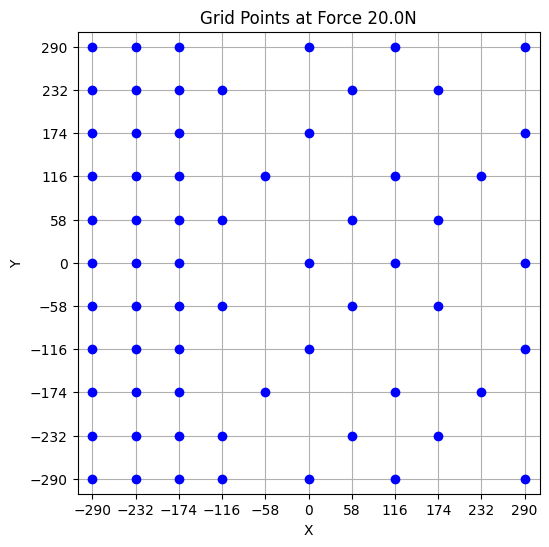

In [50]:
num_training_points = 65
data_points = generate_lhs_maximin_points(force_value=20.0, k_start=10, k_end=121, k_step=1)
norm_data_lhs = norm_data_original[norm_data_original['F'] == 20.0].reset_index(drop=True).copy()
norm_data_lhs = norm_data_lhs.merge(pd.DataFrame(data_points[num_training_points], columns=['X', 'Y']), on=['X', 'Y'], how='inner')
plot_grid_points(norm_data_lhs, force=20.0)

# Interpolation and LHS Testing

## LHS

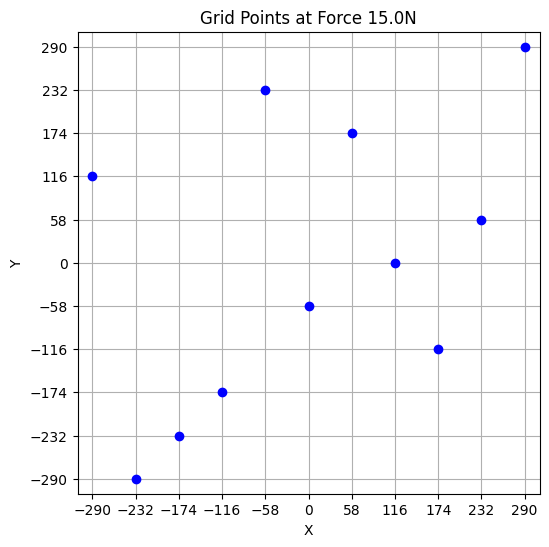

In [4]:
force = 15.0
n = 11
grid_x = np.sort(norm_data_original['X'].unique())
grid_y = np.sort(norm_data_original['Y'].unique())
sampler = qmc.LatinHypercube(d=2, seed=0)
sample = sampler.random(n=n)

# Skaliere auf Indexbereich
sample_scaled = qmc.scale(sample, l_bounds=[0, 0], u_bounds=[n, n])

# Runden auf den Index
idx = np.floor(sample_scaled).astype(int)
idx = np.clip(idx, 0, n-1)   # Sicherheit

# Map auf echte Koordinaten
data_points = np.array([[grid_x[i], grid_y[j]] for i, j in idx])
norm_data_lhs = norm_data_original[norm_data_original['F'] == force].reset_index(drop=True).copy()
norm_data_lhs = norm_data_lhs.merge(pd.DataFrame(data_points, columns=['X', 'Y']), on=['X', 'Y'], how='inner')
plot_grid_points(norm_data_lhs, force=15.0)


## Linear Interpolation between LHS data points

### Interpolation on the grid lines

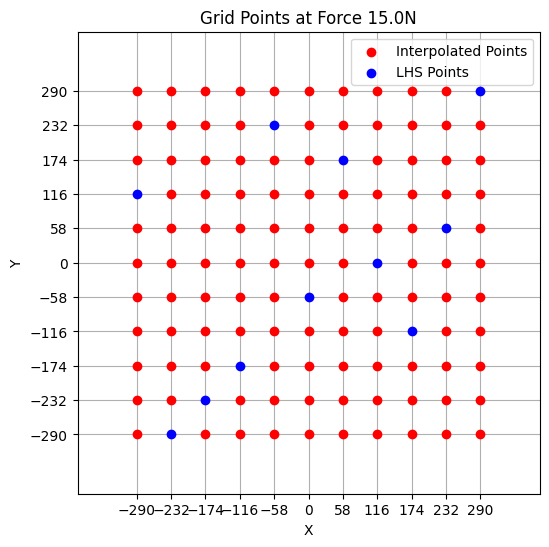

In [9]:
# LHS data to arrays
xy = norm_data_lhs[['X', 'Y']].to_numpy()
values = norm_data_lhs[['Sensor R1','Sensor R2','Sensor R3','Sensor R4','Sensor R5','Sensor R6','Sensor R7','Sensor R8']].values

# every XY point in the grid
xy_target = norm_data_original[['X', 'Y']].drop_duplicates().to_numpy()
values_interp = np.zeros([len(xy_target), 8]) # Shape: (121, 8)

# Interpolation
for i in range(8): # R1-R8
  rbf = Rbf(xy[:,0], xy[:,1], values[:, i], function='linear', smooth=0.01) # Radial Basis Function Interpolation
  values_interp[:, i] = rbf(xy_target[:,0], xy_target[:,1])

# Create new Dataframe with interpolated data
df_interp = pd.DataFrame({
    'X': xy_target[:,0],
    'Y': xy_target[:,1],
    'F': force,
    'Sensor R1': values_interp[:,0],
    'Sensor R2': values_interp[:,1],
    'Sensor R3': values_interp[:,2],
    'Sensor R4': values_interp[:,3],
    'Sensor R5': values_interp[:,4],
    'Sensor R6': values_interp[:,5],
    'Sensor R7': values_interp[:,6],
    'Sensor R8': values_interp[:,7]
})
df_interp_clean = df_interp[~df_interp.set_index(['X','Y']).index.isin(norm_data_lhs[['X', 'Y']].set_index(['X','Y']).index)] # clearing points that were used for interpolation for plotting

plt.figure(figsize=(8,6))
plt.scatter(df_interp_clean['X'], df_interp_clean['Y'], c='red', marker='o', label='Interpolated Points')
plt.scatter(norm_data_lhs['X'], norm_data_lhs['Y'], c='blue', marker='o', label='LHS Points')
plt.title(f'Grid Points at Force {force}N')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(-290 - 100, 290 + 100)
plt.ylim(-290 - 100, 290 + 100)
plt.xticks(np.linspace(-290, 290, 11))
plt.yticks(np.linspace(-290, 290, 11))
plt.gca().set_axisbelow(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.legend()
plt.show()

### Interpolation with between LHS data points randomly

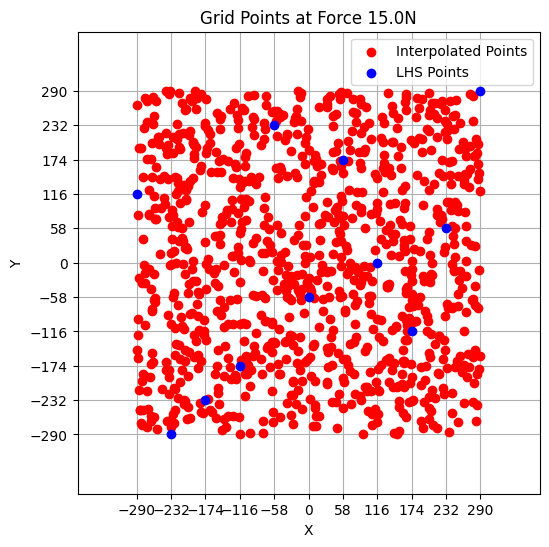

In [419]:
rng = np.random.default_rng(seed=42)
n_random_points = 1000  # z.B. 500 zusätzliche Punkte

# bounding box bestimmen aus original grid
xmin, xmax = xy_target[:,0].min(), xy_target[:,0].max()
ymin, ymax = xy_target[:,1].min(), xy_target[:,1].max()

# uniform random sampling
xy_random = np.column_stack([
    rng.uniform(xmin, xmax, n_random_points),
    rng.uniform(ymin, ymax, n_random_points)
])

values_interp_random = np.zeros((n_random_points, 8))

for i in range(8):
    rbf = Rbf(xy[:,0], xy[:,1], values[:,i], function='linear', smooth=0.01)
    values_interp_random[:, i] = rbf(xy_random[:,0], xy_random[:,1])

df_interp_random = pd.DataFrame({
    "X": xy_random[:,0],
    "Y": xy_random[:,1],
    "F": force,
    "Sensor R1": values_interp_random[:,0],
    "Sensor R2": values_interp_random[:,1],
    "Sensor R3": values_interp_random[:,2],
    "Sensor R4": values_interp_random[:,3],
    "Sensor R5": values_interp_random[:,4],
    "Sensor R6": values_interp_random[:,5],
    "Sensor R7": values_interp_random[:,6],
    "Sensor R8": values_interp_random[:,7],
})

plt.figure(figsize=(8,6))
plt.scatter(df_interp_random['X'], df_interp_random['Y'], c='red', marker='o', label='Interpolated Points')
plt.scatter(norm_data_lhs['X'], norm_data_lhs['Y'], c='blue', marker='o', label='LHS Points')
plt.title(f'Grid Points at Force {force}N')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(-290 - 100, 290 + 100)
plt.ylim(-290 - 100, 290 + 100)
plt.xticks(np.linspace(-290, 290, 11))
plt.yticks(np.linspace(-290, 290, 11))
plt.gca().set_axisbelow(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.legend()
plt.show()


## Training the Model with interpolated Data

### Model with interpolated Data on Grid lines

Test Loss XY: 16.3610


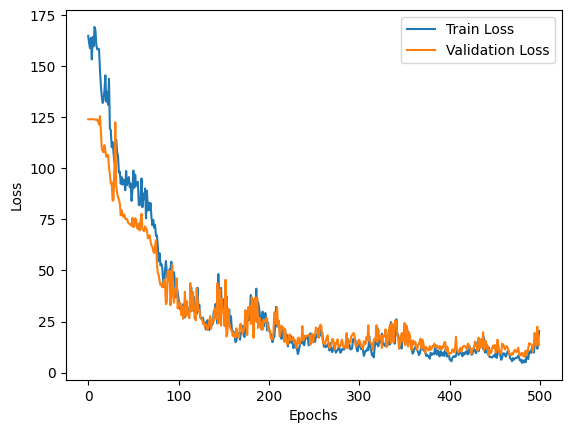

In [437]:
set_seed(42)
batch_size = 64
epochs = 500
lr = 0.0013

# Data split
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df_interp, train_size=0.7, val_size=0.15, test_size=0.15, targets='xy')
train_loader_xy, val_loader_xy, test_loader_xy = create_dataloaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=batch_size)

model_xy = MembraneModel(output_dim=2)
loss_fn_xy = nn.L1Loss()
optimizer_xy = torch.optim.Adam(model_xy.parameters(), lr=lr)
trainer_xy_lhs = Trainer(model_xy, loss_fn_xy, optimizer_xy, device='cuda')
trainer_xy_lhs.fit(train_loader_xy, val_loader_xy, epochs=epochs) # Training

# Test Losses
test_loss_xy = trainer_xy_lhs.test(test_loader_xy)
print(f'Test Loss XY: {test_loss_xy:.4f}')
trainer_xy_lhs.plot_losses()
trainer_xy_lhs.save("../../../models/membrane_model_xy_lhs_interp.pt")


### Model with interpolated Data randomly

Test Loss XY: 3.2107


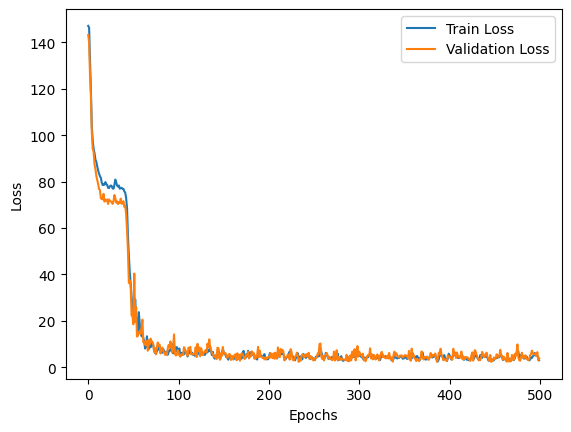

In [438]:
set_seed(42)
batch_size = 64
epochs = 500
lr = 0.0013

# Data split
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df_interp_random, train_size=0.7, val_size=0.15, test_size=0.15, targets='xy')
train_loader_xy, val_loader_xy, test_loader_xy = create_dataloaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=batch_size)

model_xy = MembraneModel(output_dim=2)
loss_fn_xy = nn.L1Loss()
optimizer_xy = torch.optim.Adam(model_xy.parameters(), lr=lr)
trainer_xy_lhs_random = Trainer(model_xy, loss_fn_xy, optimizer_xy, device='cuda')
trainer_xy_lhs_random.fit(train_loader_xy, val_loader_xy, epochs=epochs) # Training

# Test Losses
test_loss_xy = trainer_xy_lhs_random.test(test_loader_xy)
print(f'Test Loss XY: {test_loss_xy:.4f}')
trainer_xy_lhs_random.plot_losses()
trainer_xy_lhs_random.save("../../../models/membrane_model_xy_lhs_interp_randomly.pt")


## Evaluating the Model with LHS and Interpolation Data with real Data

In [439]:
batch_size = 64

### Model with interpolated Data on Grid lines

In [444]:
# Data Preparation for Testing
df_testing = norm_data_original[norm_data_original['F'] == force].reset_index(drop=True).copy()
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df_testing, train_size=0.7, val_size=0.15, test_size=0.15, targets='xy')
train_loader_xy, val_loader_xy, test_loader_xy = create_dataloaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=batch_size)

# Test the model
test_loss_xy = trainer_xy_lhs.test(test_loader_xy)
print(f'Test Loss XY: {test_loss_xy:.4f}')


Test Loss XY: 84.7850


### Model with interpolated Data randomly

In [443]:
# Data Preparation for Testing
df_testing = norm_data_original[norm_data_original['F'] == force].reset_index(drop=True).copy()
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df_testing, train_size=0.7, val_size=0.15, test_size=0.15, targets='xy')
train_loader_xy, val_loader_xy, test_loader_xy = create_dataloaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=batch_size)

# Test the model
test_loss_xy = trainer_xy_lhs_random.test(test_loader_xy)
print(f'Test Loss XY: {test_loss_xy:.4f}')

Test Loss XY: 96.1053


True XY: [174.  58.]
Predicted XY: [186.50362  77.26985]


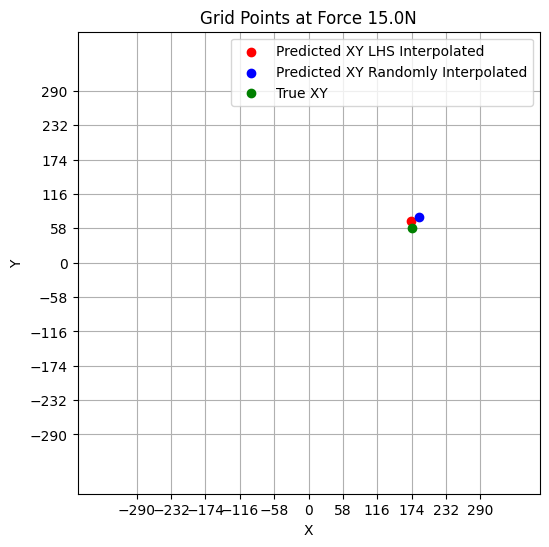

In [442]:
sample = 92
df_norm = norm_data_original[norm_data_original['F'] == 15.0].reset_index(drop=True).copy()
plt.figure(figsize=(6,6))

predictor_xy = ModelPredictor(model_class=MembraneModel, model_path="../../../models/membrane_model_xy_lhs_interp.pt", output_dim=2, mins=mins, maxs=maxs)
preds_xy = predictor_xy.predict(df_norm.iloc[sample,-8:].values)
plt.scatter(preds_xy[0], preds_xy[1], c='red', marker='o', label='Predicted XY LHS Interpolated')
predictor_xy = ModelPredictor(model_class=MembraneModel, model_path="../../../models/membrane_model_xy_lhs_interp_randomly.pt", output_dim=2, mins=mins, maxs=maxs)
preds_xy = predictor_xy.predict(df_norm.iloc[sample,-8:].values)
plt.scatter(preds_xy[0], preds_xy[1], c='blue', marker='o', label='Predicted XY Randomly Interpolated')


print("True XY:", df_norm.iloc[sample,1:3].values)
print("Predicted XY:", preds_xy)

plt.scatter(norm_data_original.iloc[sample,1], norm_data_original.iloc[sample,2], c='green', marker='o', label='True XY')
plt.title(f'Grid Points at Force {force}N')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(-290 - 100, 290 + 100)
plt.ylim(-290 - 100, 290 + 100)
plt.gca().set_aspect('equal', adjustable='box')
plt.xticks(np.linspace(-290, 290, 11))
plt.yticks(np.linspace(-290, 290, 11))
plt.gca().set_axisbelow(True)
plt.grid(True)
plt.legend()
plt.show()

